# Evaluation of held out set
* <b> To see EDA for infobox data go to [EDA.ipynb](./EDA.ipynb) </b>
* <b> To see NLP process of description text go to [NLP_training.ipynb](nlp/NLP_training.ipynb) and [NLP_evaluation.ipynb](nlp/NLP_evaluation.ipynb) </b>
* <b> To see how dbpedia raw data was first preprocessed go to [preprocessing.ipynb](preprocessing.ipynb) </b>

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, f1_score, cohen_kappa_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from dataframe_builder import DbpediaTidyDataframeBuilder

from dbpedia_common import DataFrameRepository, FINAL_DBPEDIA_RAW_CSV, ALL_RELATIONS_CSV
from anomalies_analyser import compare_population_with_web
from models import get_svr_pipeline, get_linear_pipeline, get_lxgb_pipeline, ModelEvaluator


%matplotlib inline

### We create the held out set from scratch, using previously saved files. DbpediaTidyDataframeBuilder handles all the process for us

In [2]:
%%time
final_raw_df = pd.read_csv(FINAL_DBPEDIA_RAW_CSV)
relations_df = pd.read_csv(ALL_RELATIONS_CSV)
numeric_columns = [
    '<http://dbpedia.org/ontology/areaLand>',
    '<http://dbpedia.org/ontology/areaTotal>',
    '<http://dbpedia.org/ontology/areaWater>',
    '<http://dbpedia.org/ontology/elevation>',
    '<http://dbpedia.org/ontology/populationDensity>',
]

tidyDataframeBuilder = DbpediaTidyDataframeBuilder(final_raw_df, train_set=False)
(tidyDataframeBuilder
    .with_numeric_columns(numeric_columns) # Numeric columns like AreaTotal, Elevation, AreaWater and Flag columns
    .with_counter_columns()                # Counter columns like areaLand#count, birthPlace?inv#count, areaCode#count
    .with_rare_relations_count(relations_df) # One column rare relations (less than 5% of occurence)
    .with_total_relations_count()          # One column counting how many relations a subject has
    .with_unique_relations_count()         # One column counting how many relations a subject has, excluding duplicates.
    .with_place_types()  # adds place_types column, excluding duplicates or irrelevant.
    .with_offset_types() # adds offset_types column, after cleaning
    .with_countries()    # adds countries column, after cleaning
)
dbpedia_df = tidyDataframeBuilder.build()
dbpedia_df

CPU times: user 16.8 s, sys: 595 ms, total: 17.4 s
Wall time: 17.3 s


,subject,target,<http://dbpedia.org/ontology/areaLand>,<http://dbpedia.org/ontology/areaTotal>,<http://dbpedia.org/ontology/areaWater>,<http://dbpedia.org/ontology/elevation>,<http://dbpedia.org/ontology/populationDensity>,areaCode#count,areaLand#count,areaTotal#count,areaWater#count,birthPlace?inv#count,city?inv#count,country#count,countySeat?inv#count,deathPlace?inv#count,district#count,elevation#count,foundingDate#count,governmentType#count,gridReference#count,ground?inv#count,headquarter?inv#count,hometown?inv#count,largestCity?inv#count,licenceNumber#count,location?inv#count,motto#count,nearestCity?inv#count,originalName#count,politicalLeader#count,populationAsOf#count,populationDensity#count,postalCode#count,residence?inv#count,restingPlace?inv#count,routeEnd?inv#count,routeJunction?inv#count,routeStart?inv#count,subdivision#count,subdivision?inv#count,timeZone#count,type#count,utcOffset#count,22-rdf-syntax-ns#type#count,rdf-schema#seeAlso#count,homepage#count,name#count,nick#count,rare_rel#count,total_rel#count,unique_rel#count,place_type#cat,utc_offset#cat,country#cat
0,<http://dbpedia.org/resource/'Anata>,9600.000,0.000,30600000.000,0.000,0.000,0.000,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,1,24,14,NAN,NAN,State_of_Palestine
1,<http://dbpedia.org/resource/'Anin>,3719.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,1,20,10,NAN,NAN,State_of_Palestine
2,<http://dbpedia.org/resource/A_Coruña>,244850.000,0.000,37830000.000,0.000,0.000,6613.000,1,0,1,0,91,5,1,0,15,0,0,0,1,0,4,2,5,0,0,8,2,0,0,1,0,1,1,0,1,1,0,1,3,2,0,1,0,9,3,1,1,1,10,326,52,City,NAN,Spain
3,<http://dbpedia.org/resource/Aalborg>,140897.000,0.000,0.000,0.000,5.000,954.000,1,0,0,0,108,7,1,0,6,0,1,1,0,0,3,4,8,0,0,13,0,1,0,1,1,1,1,0,0,1,0,0,2,0,1,1,2,9,3,0,1,0,14,356,48,City,"1,2",Denmark
4,"<http://dbpedia.org/resource/Aalst,_Zaltbommel>",1986.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,2,0,2,1,2,8,0,0,1,0,1,38,18,Village,"1,2",Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9903,<http://dbpedia.org/resource/Želiezovce>,6772.000,0.000,56523000.000,0.000,137.000,0.000,1,0,1,0,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,2,0,2,1,2,8,3,1,1,0,2,60,32,Town,"1,2",Slovakia
9904,<http://dbpedia.org/resource/Želino>,4110.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,2,1,2,8,0,0,1,0,1,38,16,Village,"1,2",North_Macedonia
9905,<http://dbpedia.org/resource/Žemaičių_Naumiestis>,1373.000,0.000,0.000,0.000,0.000,0.000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,2,8,0,0,1,0,1,30,12,Town,"2,3",Lithuania
9906,<http://dbpedia.org/resource/Živinice>,57765.000,0.000,291000000.000,0.000,0.000,198.000,1,0,1,0,8,0,1,0,0,0,0,0,0,0,1,2,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2,1,2,9,0,1,3,0,2,70,30,City,"1,2",Bosnia_and_Herzegovina


### Base Regressor, using the mean as estimator gives 0.7 of RMSLE

DummyRegressor RMSLE: 0.7000827750326387
DummyRegressor MSLE: 489675.49886912404
DummyRegressor R2: 0.0


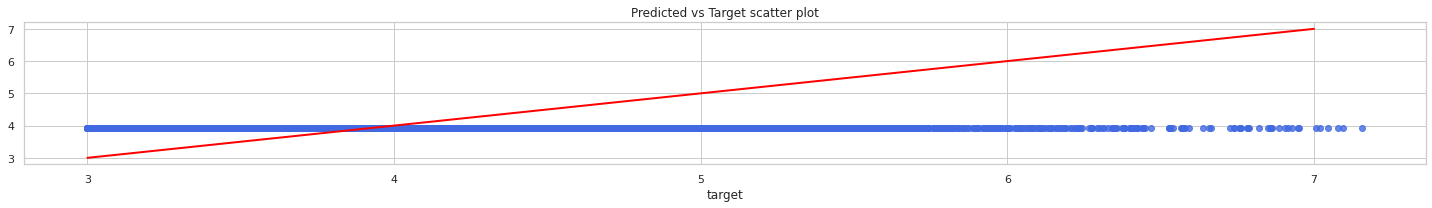

In [3]:
dummy_regr = DummyRegressor(strategy='mean')
X_test = dbpedia_df.drop(columns=['subject', 'target'])
y_test = np.log10(dbpedia_df.target)
y_test = y_test.sort_values() # These two lines are to have a nice plot below
X_test = X_test.reindex(y_test.index)

dummy_regr.fit(X_test, y_test)
pred = dummy_regr.predict(X_test)

print(f'DummyRegressor RMSLE: {mean_squared_error(y_test, pred) ** 0.5}')
print(f'DummyRegressor MSLE: {mean_squared_error(10**y_test, 10**pred) ** 0.5}')
print(f'DummyRegressor R2: {r2_score(y_test, pred)}')

fig, ax = plt.subplots(1, 1, figsize=(20,3))

sns.regplot(x=y_test, y=pred, ax=ax, color='royalblue', fit_reg=False)
ax.plot([3, 7], [3, 7], 'red', linewidth=2)
ax.set_title('Predicted vs Target scatter plot')
plt.tight_layout()

## Linear regression to find anomalies
 #### Pay atention to the red dots. Those are predictions with an error of more than 1.4 (log10 scale)

********************
Test RMSLE: 0.30838510060017743
Test RMSE: 915145.7204918928
Test R2 score: 0.8059614637182794
********************
Train RMSLE: 0.2950705722023225
Train RMSE: 295556.27979920275
Test R2 score: 0.8225086543135862


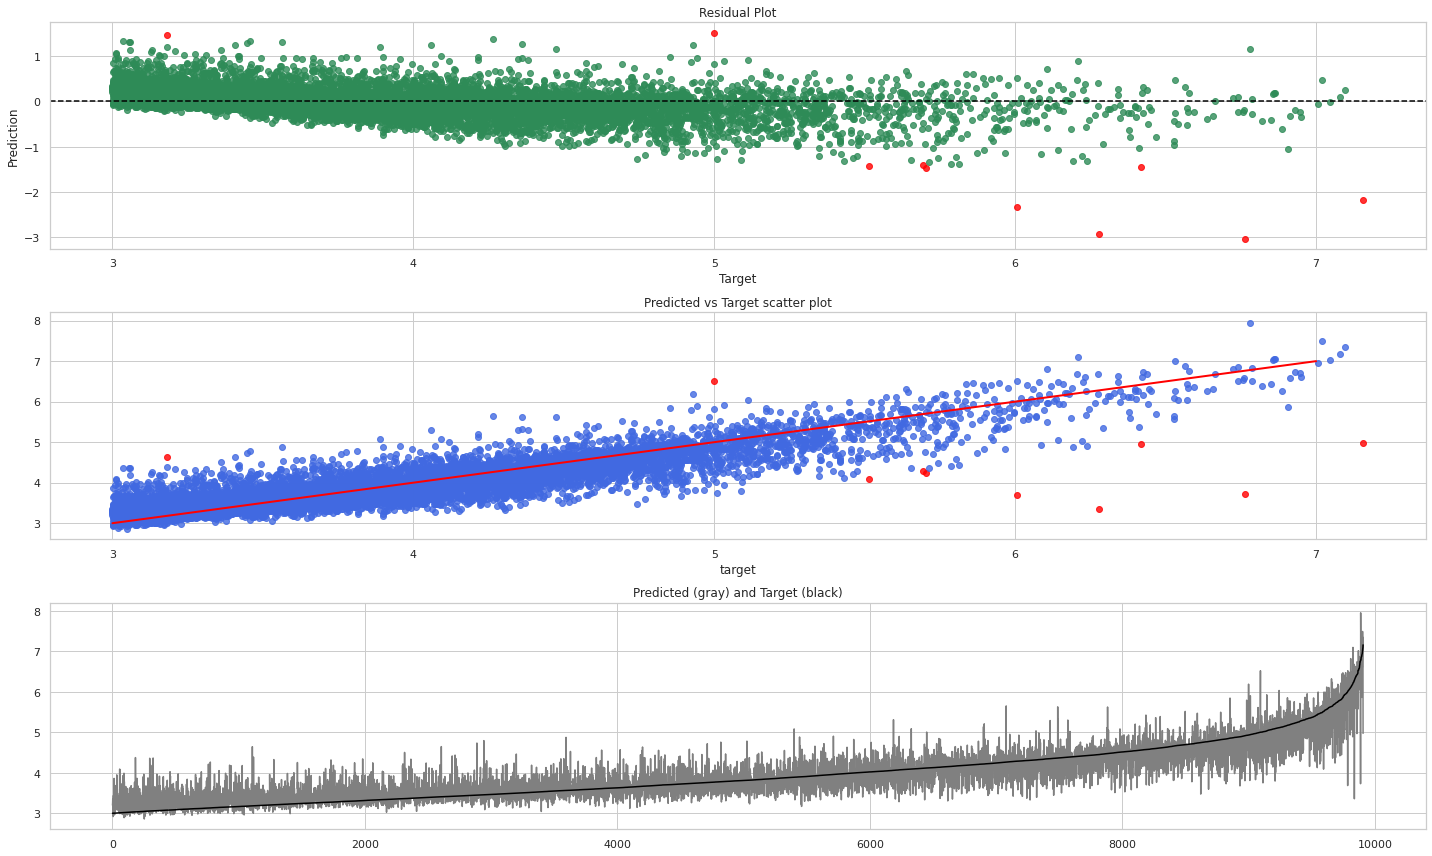

In [4]:
train_df = DataFrameRepository(version='last').get()
X_train = train_df.drop(columns=['subject', 'target'])
y_train = np.log10(train_df.target)
y = train_df.target

X_test = dbpedia_df.drop(columns=['subject', 'target'])
y_test = np.log10(dbpedia_df.target)
y_test = y_test.sort_values() # These two lines are to have a nice plot below
X_test = X_test.reindex(y_test.index)

model = TransformedTargetRegressor(regressor=get_linear_pipeline(alpha=2, countries_threshold=0.97, utc_threshold=0.95),
                                   transformer=MinMaxScaler())
model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=True)
error_analysis_df = evaluator.get_error_analysis(dbpedia_df)
evaluator.plot_results(outlier_limit=1.4)


### Worst errors have differences about 2 and 3 (log scale), which is a lot:

In [5]:
error_analysis_df.head(10)

,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
45,"Adel,_Georgia>",-3.033,6.762,3.729,5784936.000,5361.622,-5779574.378,"<http://dbpedia.org/resource/Adel,_Georgia>"
8486,Sükösd>,-2.920,6.277,3.357,1892512.000,2275.247,-1890236.753,<http://dbpedia.org/resource/Sükösd>
8859,"Tuba_City,_Arizona>",-2.322,6.006,3.684,1013162.000,4826.602,-1008335.398,"<http://dbpedia.org/resource/Tuba_City,_Arizona>"
4015,Jaú>,-2.184,7.156,4.972,14328300.000,93826.135,-14234473.865,<http://dbpedia.org/resource/Jaú>
5838,Munich>,1.518,5.000,6.518,100001.000,3294871.208,3194870.208,<http://dbpedia.org/resource/Munich>
4208,Karol_Bagh>,-1.464,5.703,4.239,505242.000,17344.456,-487897.544,<http://dbpedia.org/resource/Karol_Bagh>
6036,New_Athos>,1.462,3.181,4.643,1518.000,43964.474,42446.474,<http://dbpedia.org/resource/New_Athos>
8514,Taiz>,-1.450,6.417,4.967,2612222.000,92654.183,-2519567.817,<http://dbpedia.org/resource/Taiz>
4998,Logan_City>,-1.425,5.514,4.089,326615.000,12280.843,-314334.157,<http://dbpedia.org/resource/Logan_City>
3942,Ixtapaluca>,-1.402,5.695,4.293,495563.000,19624.235,-475938.765,<http://dbpedia.org/resource/Ixtapaluca>


### The subjects with the biggest differences are: 
  * Adel Georgia
  * Sükösd
  * Tuba_City Arizona
  * Jaú
### After running a custom tool, we'll see their populations are different in wikipedia.com (so, they have an incorrect value in dbpedia infoboxes). So we'll fix them (plus other ones found through the process)

### The tool says it found some errors and some suspicious subjects

In [6]:
compare_population_with_web(error_analysis_df, limit=7).head(10)

1 Errors found while parsing wikipedia webpage. Make a manual check for: ['Tuba_City,_Arizona']
There are 3 suspicious subjects! Check if found values are real and fix the records


,pretty_subject,error,expected_value,found_value,relative_log_diff,message,wiki_link,subject
2,"Tuba_City,_Arizona",True,1013162.000,nan,0.000,Failed to get population from: <td><span><span...,https://en.wikipedia.org/wiki/Tuba_City%2C_Ari...,"<http://dbpedia.org/resource/Tuba_City,_Arizona>"
0,"Adel,_Georgia",False,5784936.000,5334.000,3.035,,https://en.wikipedia.org/wiki/Adel%2C_Georgia,"<http://dbpedia.org/resource/Adel,_Georgia>"
3,Jaú,False,14328300.000,143283.000,2.000,,https://en.wikipedia.org/wiki/Ja%C3%BA,<http://dbpedia.org/resource/Jaú>
4,Munich,False,100001.000,1471508.000,1.168,,https://en.wikipedia.org/wiki/Munich,<http://dbpedia.org/resource/Munich>
1,Sükösd,False,1892512.000,1892512.000,0.000,,https://en.wikipedia.org/wiki/S%C3%BCk%C3%B6sd,<http://dbpedia.org/resource/Sükösd>
5,Karol_Bagh,False,505242.000,505242.000,0.000,,https://en.wikipedia.org/wiki/Karol_Bagh,<http://dbpedia.org/resource/Karol_Bagh>
6,New_Athos,False,1518.000,1518.000,0.000,,https://en.wikipedia.org/wiki/New_Athos,<http://dbpedia.org/resource/New_Athos>


### After manual checking I found all these subjects were wrong. I fixed the values and now we are ready to predict the held out data with our best model

In [7]:
fixed_dbpedia_df = dbpedia_df.copy()

fixed_populations = {
    '<http://dbpedia.org/resource/Tuba_City,_Arizona>': 8611, # source: https://en.wikipedia.org/wiki/Tuba_City,_Arizona
    '<http://dbpedia.org/resource/Adel,_Georgia>': 5334, # source: https://en.wikipedia.org/wiki/Adel,_Georgia
    '<http://dbpedia.org/resource/Jaú>': 143283,         # source: https://en.wikipedia.org/wiki/Funes,_Santa_Fe
    '<http://dbpedia.org/resource/Funes,_Santa_Fe>': 23520, # source: https://en.wikipedia.org/wiki/Ja%C3%BA
    '<http://dbpedia.org/resource/Munich>': 1471508,     # source: https://en.wikipedia.org/wiki/Munich
    '<http://dbpedia.org/resource/Dettenhausen>': 5431,  # source https://en.wikipedia.org/wiki/Dettenhausen
    '<http://dbpedia.org/resource/Zhob>': 46248,         # source: https://en.wikipedia.org/wiki/Zhob
    '<http://dbpedia.org/resource/Sükösd>': 3627,        # source: https://www.citypopulation.de/en/hungary/bacskiskun/baja/21245__s%C3%BCk%C3%B6sd/
    '<http://dbpedia.org/resource/Mahendragarh>': 29128, # Found while running SVR. Source: https://en.wikipedia.org/wiki/Mahendragarh
    '<http://dbpedia.org/resource/Hatsingimari>': 3445, # Found while running LXGBM + NLP. Source: https://en.wikipedia.org/wiki/Hatsingimari
}
for name, target in fixed_populations.items():
    fixed_dbpedia_df.loc[fixed_dbpedia_df['subject'] == name, 'target'] = target

#fixed_dbpedia_df.loc[fixed_dbpedia_df['subject'].isin(list(fixed_populations.keys())), ['subject', 'target']]

## LGBM + NPL (from [here](nlp))
* I'll add a new feature to LGBM based on NLP predictions over description data. To do that, I need make an OOB prediction to avoid overfitting. Then, those predictions will be a feature to help the model with the regression problem.

## LGBM (infobox data) + NLP (short description of each city)
### We create 2 datasets: 
* <b> df_nlp will just have descriptions for each city (from short-abstracts file) and </b>
* <b> df_infobox is the one with all dbpedia features (from dbpedia infobox).</b>
* <b> Both of them are split in train and held_out using previously saved target dataset </b>

In [8]:
import os.path
from nlp.helper_functions import (discretize_target, get_short_descriptions, nlp_predict, 
                                  evaluate as evaluate_categorical, BIN_LABELS, BINS)
from dbpedia_common import TARGET_DEV_CSV, TARGET_HELD_OUT_CSV
train_df = DataFrameRepository(version='last').get()

target_df = pd.concat([pd.read_csv(TARGET_DEV_CSV), pd.read_csv(TARGET_HELD_OUT_CSV)])

df_nlp = target_df.copy()
df_nlp['target'] = discretize_target(df_nlp, BIN_LABELS, BINS)
df_nlp['description'] = df_nlp['subject'].map(get_short_descriptions())
df_nlp = df_nlp.drop(df_nlp[df_nlp.description.isnull()].index).reset_index(drop=True) 
train_df_nlp = df_nlp.loc[df_nlp.subject.isin(train_df.subject)].copy()
held_out_nlp = df_nlp.loc[df_nlp.subject.isin(fixed_dbpedia_df.subject)].copy()

df_infobox = DataFrameRepository(version='last').get()
train_df_infobox = df_infobox[df_infobox.subject.isin(train_df_nlp.subject)].copy()
held_out_infobox = fixed_dbpedia_df[fixed_dbpedia_df.subject.isin(held_out_nlp.subject)].copy()

## To be able to feed Infobox model with NLP data in the training fase, we need to make OOB predictions to avoid overfitting. 
* It takes 20 minutes, so it is cached

In [9]:
nlp_cache_csv = 'nlp_train_prediction_evaluation.csv'
if os.path.isfile(nlp_cache_csv):
    nlp_prediction = pd.read_csv(nlp_cache_csv)
else:
    strat_split = StratifiedShuffleSplit(n_splits=10, test_size=0.20, random_state=42)
    predicted_indices = set([])
    nlp_prediction = train_df_nlp.subject.to_frame()
    nlp_prediction['nlp_prediction'] = -1
    for train_index, test_index in strat_split.split(train_df_nlp, train_df_nlp['target']):
        predicted_indices = predicted_indices.union(test_index.tolist())
        X_train, X_test = train_df_nlp.iloc[train_index].drop(columns='target'), train_df_nlp.iloc[test_index].drop(columns='target')
        y_train, _y_test = train_df_nlp.iloc[train_index].target, train_df_nlp.iloc[test_index].target
        nlp_prediction.loc[nlp_prediction.iloc[test_index].index, ['nlp_prediction']] = nlp_predict(X_train, y_train, X_test, upsampling_threshold=10000)

    not_predicted = list(set(nlp_prediction.index) - set(nlp_prediction.iloc[list(predicted_indices)].index))
    train = train_df_nlp.iloc[list(predicted_indices)]
    X_train, y_train = train.drop(columns='target'), train.target
    X_test = train_df_nlp.loc[not_predicted].drop(columns='target')

    nlp_prediction.loc[not_predicted, 'nlp_prediction'] = nlp_predict(X_train, y_train, X_test, upsampling_threshold=10000)
    nlp_prediction.to_csv(nlp_cache_csv, index=False)
nlp_prediction.head(3)    

,subject,nlp_prediction
0,<http://dbpedia.org/resource/'Amran>,5
1,"<http://dbpedia.org/resource/'t_Zand,_Schagen>",1
2,<http://dbpedia.org/resource/100_Mile_House>,4


### We also need to predict held_out targets, to feed Infobox model in evaluation fase

In [10]:
X_train_nlp, y_train_nlp = train_df_nlp.drop(columns='target'), train_df_nlp.target
X_held_out_nlp, y_held_out_nlp = held_out_nlp.drop(columns='target'), held_out_nlp.target

nlp_held_out_prediction = X_held_out_nlp.subject.to_frame()
nlp_held_out_prediction['nlp_prediction'] = nlp_predict(X_train_nlp, y_train_nlp, X_held_out_nlp, upsampling_threshold=2500)

## Lastly, we merge train df from infobox dataset with nlp predictions of description text.
* We add that prediction as a feature to LGBM and improves our RMSLE from 0.26 to 0.22, which is pretty good.
* We also went from a Quadratic Kappa score of 0.88 to 0.93.
* Finally, the biggest error we have in the prediction is about 1.38 (log scale)
* All values in the corners of confussion matrix are 0, which means we don't have heavy mistakes

********************
Test RMSLE: 0.22703404944911137
Test RMSE: 219286.3171932243
********************
Train RMSLE: 0.19271829178240615
Train RMSE: 183010.734360593
********************
Quadratic Kappa Score: 0.93
F1 score Micro: 0.75
F1 score Macro: 0.68


,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
545,Bandundu_Province>,-1.385,6.906,5.522,8062463.000,332551.044,-7729911.956,<http://dbpedia.org/resource/Bandundu_Province>
4997,Logan_City>,-1.381,5.514,4.133,326615.000,13572.313,-313042.687,<http://dbpedia.org/resource/Logan_City>
3607,"Hidden_Hills,_California>",1.355,3.269,4.624,1856.000,42028.039,40172.039,"<http://dbpedia.org/resource/Hidden_Hills,_Cal..."
5990,Naxalbari>,1.347,3.209,4.556,1618.000,35934.493,34316.493,<http://dbpedia.org/resource/Naxalbari>
8680,"Thornton,_California>",1.320,3.053,4.373,1131.000,23620.108,22489.108,"<http://dbpedia.org/resource/Thornton,_Califor..."
...,...,...,...,...,...,...,...,...
6252,Nueva_Gorgona>,-0.000,3.610,3.610,4075.000,4074.685,-0.315,<http://dbpedia.org/resource/Nueva_Gorgona>
1030,Bouctouche>,-0.000,3.373,3.373,2361.000,2360.833,-0.167,<http://dbpedia.org/resource/Bouctouche>
7627,San_Luis_Amatlán>,0.000,3.531,3.531,3393.000,3393.233,0.233,<http://dbpedia.org/resource/San_Luis_Amatlán>
8895,"Tyrone,_Pennsylvania>",0.000,3.739,3.739,5477.000,5477.275,0.275,"<http://dbpedia.org/resource/Tyrone,_Pennsylva..."


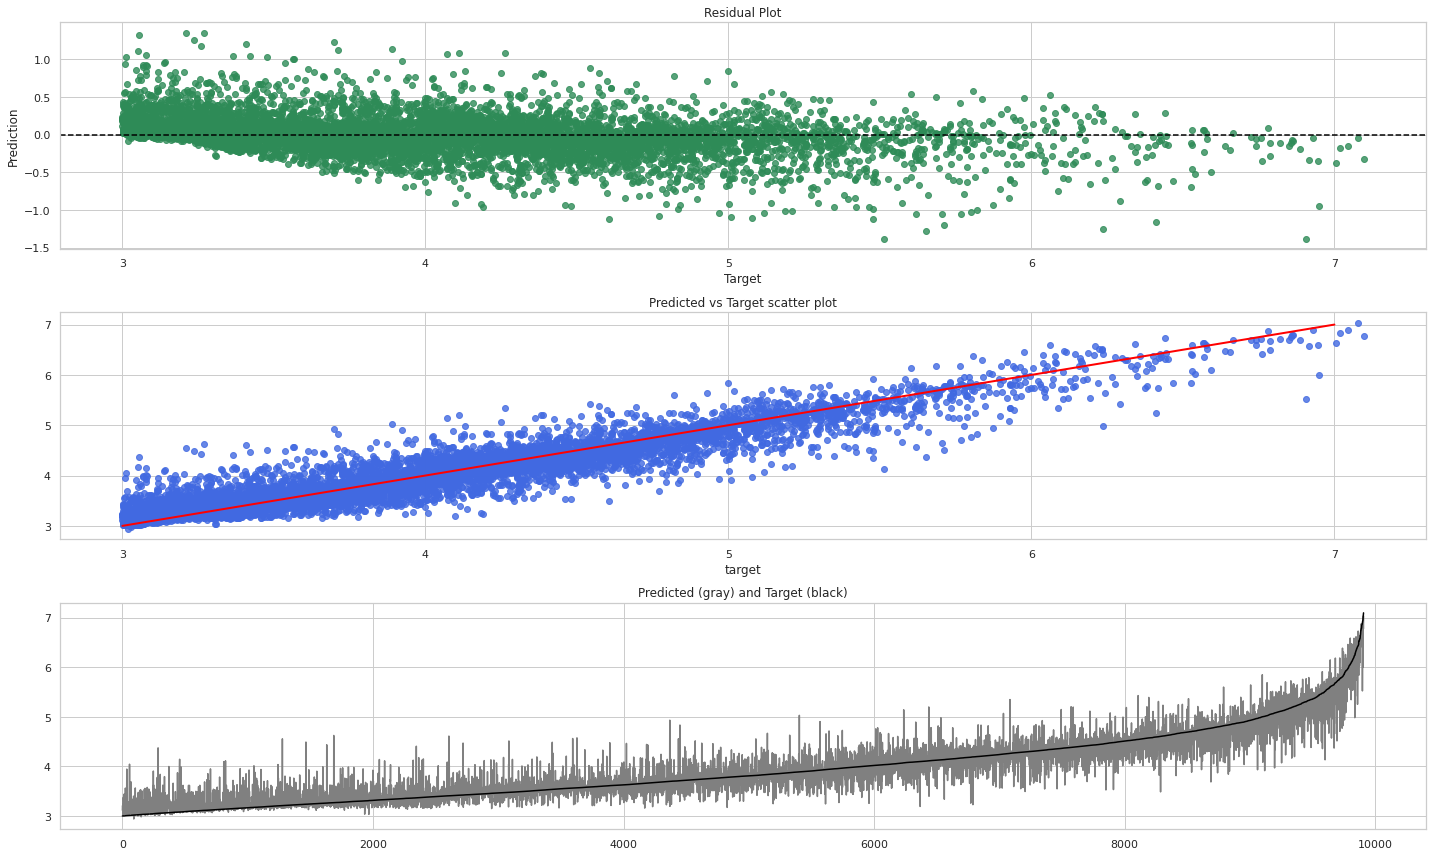

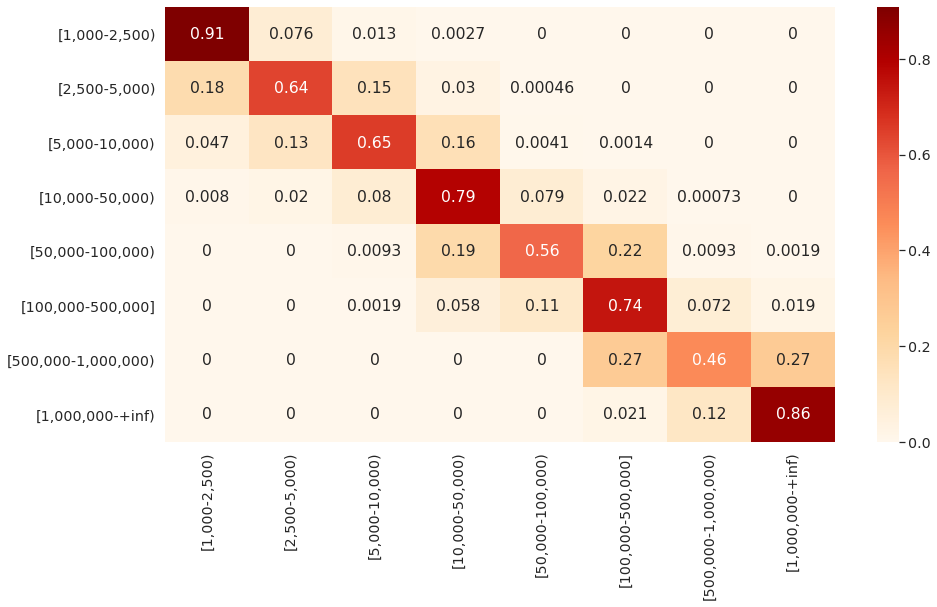

In [11]:
merged_train_df = train_df_infobox.merge(nlp_prediction, on='subject', how='left')
merged_held_out_df = held_out_infobox.merge(nlp_held_out_prediction, on='subject', how='left')

X_train, y_train = merged_train_df.drop(columns='target'), np.log10(merged_train_df.target)
y_held_out = np.log10(merged_held_out_df.target).sort_values()
X_held_out = merged_held_out_df.drop(columns='target').reindex(y_held_out.index)

model = TransformedTargetRegressor(regressor=get_lxgb_pipeline(), transformer=MinMaxScaler())
model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_held_out, y_held_out, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=False)
evaluator.plot_results()
print('********************')
pred_bin = pd.cut(10**test_pred, bins=BINS, labels=BIN_LABELS).astype(int)
y_test_bin = pd.cut(10**y_held_out, bins=BINS, labels=BIN_LABELS).astype(int)

evaluate_categorical(y_test_bin, pred_bin)
error_analysis_df = evaluator.get_error_analysis(merged_held_out_df)
error_analysis_df

Log absolute errors greater than 1: <b>0.38%</b>

Log absolute errors greater than 0.5: <b>4.63%</b>

Log absolute errors greater than 0.25: <b>19.35%</b>

Log absolute errors greater than 0.1: <b>48.87%</b>

Text(0.5, 1.0, 'Log errors Boxplot')

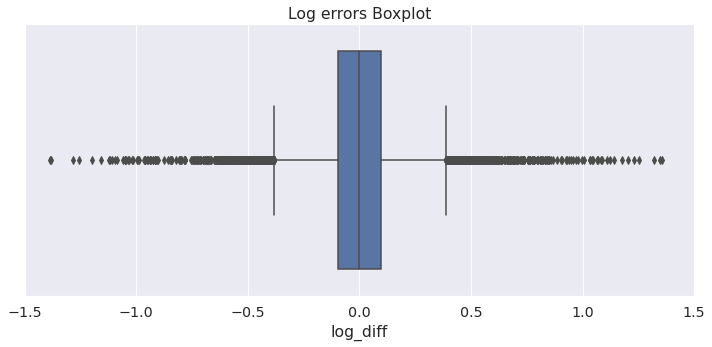

In [61]:
from IPython.display import Markdown
display(Markdown(f'Log absolute errors greater than 1: <b>{round((error_analysis_df.log_diff.abs() > 1).mean(), 4) * 100}%</b>'))
display(Markdown(f'Log absolute errors greater than 0.5: <b>{round((error_analysis_df.log_diff.abs() > 0.5).mean(), 4) * 100}%</b>'))
display(Markdown(f'Log absolute errors greater than 0.25: <b>{round((error_analysis_df.log_diff.abs() > 0.25).mean(), 4) * 100}%</b>'))
display(Markdown(f'Log absolute errors greater than 0.1: <b>{round((error_analysis_df.log_diff.abs() > 0.1).mean()  * 100, 2)}%</b>'))

plt.figure(figsize=(12,5))
ax = sns.boxplot(x=error_analysis_df.log_diff)
ax.set_xlim(-1.5,1.5)
ax.set_title('Log errors Boxplot')

## Below there are some models I tried (Without NLP) that gave worse results
* Output was cleaned to make the notebook lighter

## Polinomial regression
 * **R2**: 0.8128
 * **RMSLE**: 0.302

In [1]:
train_df = DataFrameRepository(version='last').get()
X_train = train_df.drop(columns=['subject', 'target'])
y_train = np.log10(train_df.target)

y_test = np.log10(fixed_dbpedia_df.target).sort_values()
X_test = fixed_dbpedia_df.drop(columns=['subject', 'target']).reindex(y_test.index)


model = TransformedTargetRegressor(regressor=get_linear_pipeline(alpha=2, countries_threshold=0.97, utc_threshold=0.95),
                                   transformer=MinMaxScaler())
model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=True)
error_analysis_df = evaluator.get_error_analysis(fixed_dbpedia_df)
evaluator.plot_results(outlier_limit=1.4)
error_analysis_df.head(10)

# ********************
# Test RMSLE: 0.3024723918655315
# Test RMSE: 901337.3140176593
# Test R2 score: 0.8121576410653448
# ********************

## Run SVR with fixed data
  * **RMSLE**: 0.27757

In [2]:
%%time
train_df = DataFrameRepository(version='last').get()
X_train = train_df.drop(columns=['subject', 'target'])
y_train = np.log10(train_df.target)

y_test = np.log10(fixed_dbpedia_df.target).sort_values()
X_test = fixed_dbpedia_df.drop(columns=['subject', 'target']).reindex(y_test.index)

pipeline = get_svr_pipeline(countries_threshold=0.97, utc_threshold=0.95)
model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=False)
error_analysis_df = evaluator.get_error_analysis(fixed_dbpedia_df)
evaluator.plot_results(outlier_limit=1.4)
error_analysis_df.head(10)

# ********************
# Test RMSLE: 0.27757531360824356
# Test RMSE: 240662.33139745996
# ********************

## Run Light XGBM with fixed data
  * **RMSLE**: 0.2659

In [3]:
%%time
train_df = DataFrameRepository(version='last').get()
X_train = train_df.drop(columns=['subject', 'target'])
y_train = np.log10(train_df.target)

y_test = np.log10(fixed_dbpedia_df.target).sort_values()
X_test = fixed_dbpedia_df.drop(columns=['subject', 'target']).reindex(y_test.index)

pipeline = get_lxgb_pipeline()
model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=False)
error_analysis_df = evaluator.get_error_analysis(fixed_dbpedia_df)
evaluator.plot_results(outlier_limit=1.4)
error_analysis_df.head(10)

# ********************
# Test RMSLE: 0.26362582977224047
# Test RMSE: 222747.24231588602
# ********************